In [0]:
# helper to download the Data Set from Google Drive

import requests
import os

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


In [0]:
# RAVDESS_original.zip https://drive.google.com/open?id=1WyJsDuxJlUObBCFrNZLAXM2w4-sp0CxN
# file_id = '1WyJsDuxJlUObBCFrNZLAXM2w4-sp0CxN'

# RAVDESS_trimmed.zip https://drive.google.com/open?id=1pFum_YGf2C82HJvMwt0gi8apj6PJLi0s
#file_id = '1pFum_YGf2C82HJvMwt0gi8apj6PJLi0s'

# RAVDESS_enriched.zip https://drive.google.com/open?id=1LG42oQTSs6HWMLsdqhFKbADA2wi8234_
# file_id = '1LG42oQTSs6HWMLsdqhFKbADA2wi8234_'

# RAVDESS_spectogram.zip https://drive.google.com/open?id=1jDb2GDnapxx-5bhRR4rudVLxd4ajrpF-
# file_id = '1jDb2GDnapxx-5bhRR4rudVLxd4ajrpF-'

# RAVDESS_train.zip https://drive.google.com/open?id=1a2TRcqj5ySMWwetfU3Zgq4FE-highOKK
file_id = '1a2TRcqj5ySMWwetfU3Zgq4FE-highOKK'

destination = 'RAVDESS.zip'

if not os.path.exists(destination):
    download_file_from_google_drive(file_id, destination)

In [3]:
!ls -lh

total 506M
-rw-r--r-- 1 root root 506M Nov 19 20:17 RAVDESS.zip
drwxr-xr-x 1 root root 4.0K Nov 15 16:31 sample_data


In [4]:
!unzip -n RAVDESS.zip

Archive:  RAVDESS.zip
   creating: RAVDESS/train_valid/
   creating: RAVDESS/train_valid/train/
   creating: RAVDESS/train_valid/train/happy/
  inflating: RAVDESS/train_valid/train/happy/03-01-03-02-01-02-02-00-1000.png  
  inflating: RAVDESS/train_valid/train/happy/03-01-03-01-02-01-10-02-2500.png  
  inflating: RAVDESS/train_valid/train/happy/03-01-03-01-01-01-14-02-1000.png  
  inflating: RAVDESS/train_valid/train/happy/03-01-03-02-01-02-03-02-2500.png  
  inflating: RAVDESS/train_valid/train/happy/03-01-03-02-01-02-24-02-1500.png  
  inflating: RAVDESS/train_valid/train/happy/03-01-03-02-01-01-04-00-500.png  
  inflating: RAVDESS/train_valid/train/happy/03-01-03-02-02-01-01-01-2500.png  
  inflating: RAVDESS/train_valid/train/happy/03-01-03-02-01-02-03-00-2500.png  
  inflating: RAVDESS/train_valid/train/happy/03-01-03-01-01-01-06-01-2500.png  
  inflating: RAVDESS/train_valid/train/happy/03-01-03-02-01-01-12-00-2500.png  
  inflating: RAVDESS/train_valid/train/happy/03-01-03-01-02

In [11]:
!ls RAVDESS/train_valid/train -lh

total 1.7M
drwxr-xr-x 2 root root 232K Nov 18 17:33 angry
drwxr-xr-x 2 root root 240K Nov 18 17:33 calm
drwxr-xr-x 2 root root 260K Nov 18 17:33 disgust
drwxr-xr-x 2 root root 220K Nov 18 17:33 fearful
drwxr-xr-x 2 root root 228K Nov 18 17:33 happy
drwxr-xr-x 2 root root 104K Nov 18 17:33 neutral
drwxr-xr-x 2 root root 244K Nov 18 17:33 sad
drwxr-xr-x 2 root root 204K Nov 18 17:33 surprised


In [0]:
import numpy as np
import pandas as pd
import librosa
from scipy.signal import spectrogram
import math
import matplotlib.pyplot as plt
import random
import re
import gc
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
def name_to_data(self, path):
    numbers = re.findall(r'\d+', path) # numbers in the name of the audio file
    # spectogram = Image.open(spectogram_path) # consumes too much memory
    return [
        self.emotions[numbers[2]],
        self.emotion_intensities[numbers[3]],
        self.statements[numbers[4]],
        self.repetitions[int(numbers[5])-1],
        numbers[6], 
        self.actors[numbers[6]], 
        path
    ]


# Creates the Data Frame for the RAVDESS
def create_dataframe(self):
    print('Create dataframe')
    data = []
    specograms_paths = self.get_split_image_paths()
    for specograms_path in specograms_paths:
        data.append(self.name_to_data(specograms_path))

    df = pd.DataFrame(  # contruct DataFrame from data
        { 
            'emotion'           : pd.Categorical([row[0] for row in data]),
            'emotion_intensity' : pd.Categorical([row[1] for row in data]),
            'statement'         : pd.Categorical([row[2] for row in data]),
            'repetition'        : pd.Categorical([row[3] for row in data]),
            'actor'             : pd.Categorical([row[4] for row in data]),
            'actor_gender'      : pd.Categorical([row[5] for row in data]),
            'image'             : pd.Categorical([row[6] for row in data])
        })

    # one-hot encode columns
    df = pd.get_dummies(df, columns=["emotion", "emotion_intensity", "statement", "repetition", "actor", "actor_gender"])
    return df

In [0]:
# create directory path helper variables
base_dir = 'RAVDESS/train_valid/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
import numpy as np

In [0]:
inceptionv3_img_height=299
inceptionv3_img_width=299

In [17]:
# load the pre-trained InceptionV3 model without the fully-connected layers
base_model = InceptionV3(weights='imagenet', include_top=False)

# create new top layers for the model
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Fully connected layer with Relu activation
x = Dense(1024, activation='relu')(x)

# The output layer has 8 neurons, as we have 8 different emotion in the data set. The activation is set to softmax.
predictions = Dense(8, activation='softmax')(x)

# Finalize the model
model = Model(inputs=base_model.input, outputs=predictions)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
87916544/87910968 [==============================] - 8s 0us/step


In [0]:
# Freeze the InceptionV3 layers as we will pre train the top layers that we have added
for layer in base_model.layers:
    layer.trainable = False

# We use categorical_crossentropy as we have multiple classes
model.compile(optimizer='rmsprop', metrics=['accuracy'], loss='categorical_crossentropy')

In [29]:
print("Number of original train images: " + str(sum([len(files) for r, d, files in os.walk(train_dir)])))
print("Number of original validation images: " + str(sum([len(files) for r, d, files in os.walk(validation_dir)])))

Number of original train images: 28701
Number of original validation images: 12306


In [33]:
# Load the images with ImageDataGenerator. The original images are not augmented as we have a fixed time series images. The Image is rescaled to 0..1 range.
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0, width_shift_range=0, height_shift_range=0, zoom_range=0, horizontal_flip=False, vertical_flip=False)
validation_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0, width_shift_range=0, height_shift_range=0, zoom_range=0, horizontal_flip=False, vertical_flip=False)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(inceptionv3_img_height, inceptionv3_img_width), batch_size=32, class_mode='categorical', seed=42)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(inceptionv3_img_height, inceptionv3_img_width), batch_size=32, class_mode='categorical', seed=42)

Found 28701 images belonging to 8 classes.
Found 12306 images belonging to 8 classes.


In [34]:
# The model used the train generator to load and randomize the data. 
model.fit(train_generator,steps_per_epoch=5,validation_data=validation_generator,validation_steps=10,epochs=3)

Epoch 1/3
5/5 [==============================] - 150s 30s/step - loss: 9.6337 - acc: 0.1312 - val_loss: 5.2031 - val_acc: 0.1219
Epoch 2/3
5/5 [==============================] - 137s 27s/step - loss: 3.2775 - acc: 0.1312 - val_loss: 2.3488 - val_acc: 0.1219
Epoch 3/3
5/5 [==============================] - 137s 27s/step - loss: 2.3314 - acc: 0.1750 - val_loss: 2.2018 - val_acc: 0.1375


In [0]:
# Allow the upper layers of the InceptionV3 model to be trained
for layer in model.layers[:172]:
       layer.trainable = False
for layer in model.layers[172:]:
       layer.trainable = True

In [0]:
# We recompile the model to take affect
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'], loss='categorical_crossentropy')

In [38]:
history = model.fit_generator(train_generator,steps_per_epoch=5,validation_data=validation_generator,validation_steps=10,epochs=3)

Epoch 1/3
5/5 [==============================] - 186s 37s/step - loss: 2.2169 - acc: 0.1813 - val_loss: 2.1873 - val_acc: 0.1375
Epoch 2/3
5/5 [==============================] - 173s 35s/step - loss: 2.3306 - acc: 0.1125 - val_loss: 2.1630 - val_acc: 0.1406
Epoch 3/3
5/5 [==============================] - 171s 34s/step - loss: 2.1412 - acc: 0.1312 - val_loss: 2.1460 - val_acc: 0.1281


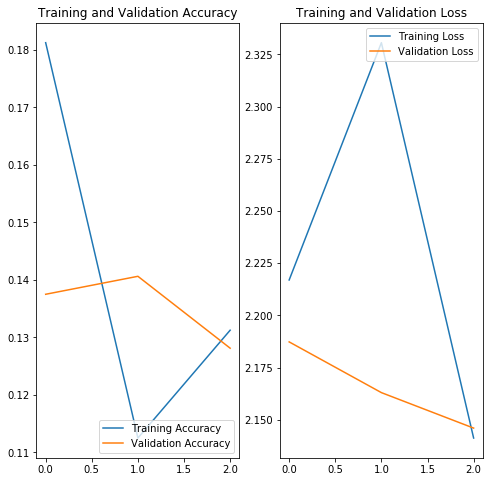

In [39]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(3)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()